In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error


In [2]:
# AWS와 PM 데이터프레임 로드
aws_df = pd.read_csv("AWS_TRAIN.csv")
pm_df  = pd.read_csv("PM_TRAIN.csv")
aws_df
aws_df_missing_values = aws_df.isnull().sum()
print(aws_df_missing_values)


연도            0
일시            0
지점            0
기온(°C)        0
풍향(deg)       0
             ..
기온(°C).29     0
풍향(deg).29    0
풍속(m/s).29    0
강수량(mm).29    0
습도(%).29      0
Length: 182, dtype: int64


In [3]:
# 데이터 결합
combined_df = pd.concat([aws_df, pm_df], axis=1)

In [4]:
combined_df

,연도,일시,지점,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),지점.1,기온(°C).1,...,측정소.12,PM2.5.12,측정소.13,PM2.5.13,측정소.14,PM2.5.14,측정소.15,PM2.5.15,측정소.16,PM2.5.16
0,0,01-01 00:00,0,0.154818,0.410833,0.033248,0.0,0.830,1,0.173776,...,42,0.032,43,0.052,44,0.036,45,0.052,46,0.072
1,0,01-01 01:00,0,0.142180,0.148611,0.030691,0.0,0.853,1,0.176935,...,42,0.032,43,0.064,44,0.040,45,0.088,46,0.076
2,0,01-01 02:00,0,0.173776,0.203889,0.040921,0.0,0.802,1,0.180095,...,42,0.048,43,0.072,44,0.032,45,0.048,46,0.080
3,0,01-01 03:00,0,0.169036,0.330556,0.048593,0.0,0.816,1,0.178515,...,42,0.044,43,0.072,44,0.040,45,0.052,46,0.076
4,0,01-01 04:00,0,0.169036,0.000000,0.007673,0.0,0.827,1,0.164297,...,42,0.036,43,0.052,44,0.040,45,0.088,46,0.096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,3,12-31 19:00,0,0.265403,0.101944,0.025575,0.0,0.596,1,0.287520,...,42,0.036,43,0.020,44,0.036,45,0.040,46,0.060
35060,3,12-31 20:00,0,0.252765,0.338056,0.015345,0.0,0.594,1,0.281201,...,42,0.036,43,0.036,44,0.060,45,0.048,46,0.052
35061,3,12-31 21:00,0,0.257504,0.970556,0.040921,0.0,0.575,1,0.260664,...,42,0.040,43,0.028,44,0.048,45,0.072,46,0.044
35062,3,12-31 22:00,0,0.262243,0.908056,0.030691,0.0,0.611,1,0.262243,...,42,0.052,43,0.036,44,0.040,45,0.060,46,0.052


In [5]:
# 결합된 데이터를 사용하여 LSTM 모델 학습 및 예측
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

In [6]:
data = combined_df[['지점', '기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)', 'PM2.5']]

In [7]:
# 데이터 분할
train_size = int(len(data) * 0.7)
test_size = len(data) - train_size
train, test = data.values[0:train_size,:], data.values[train_size:len(data),:]


In [8]:
# 시퀀스 데이터 생성
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [9]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 7)))  # 지점 데이터를 추가하려면 입력 차원을 7로 변경해야 합니다.
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

Metal device set to: Apple M1


In [10]:
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10


2023-05-08 20:34:04.891872: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24541/24541 - 105s - loss: 5.3672e-04 - 105s/epoch - 4ms/step
Epoch 2/10
24541/24541 - 102s - loss: 4.1054e-04 - 102s/epoch - 4ms/step
Epoch 3/10
24541/24541 - 103s - loss: 3.9589e-04 - 103s/epoch - 4ms/step
Epoch 4/10
24541/24541 - 103s - loss: 3.8856e-04 - 103s/epoch - 4ms/step
Epoch 5/10
24541/24541 - 106s - loss: 3.8273e-04 - 106s/epoch - 4ms/step
Epoch 6/10
24541/24541 - 104s - loss: 3.7905e-04 - 104s/epoch - 4ms/step
Epoch 7/10
24541/24541 - 105s - loss: 3.7726e-04 - 105s/epoch - 4ms/step
Epoch 8/10
24541/24541 - 103s - loss: 3.7667e-04 - 103s/epoch - 4ms/step
Epoch 9/10
24541/24541 - 103s - loss: 3.7225e-04 - 103s/epoch - 4ms/step
Epoch 10/10
24541/24541 - 103s - loss: 3.7283e-04 - 103s/epoch - 4ms/step


In [12]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


329/329 [==============================] - 1s 2ms/step


In [13]:
# 모델 평가
train_mse = mean_squared_error(trainY, trainPredict)
test_mse = mean_squared_error(testY, testPredict)
print('Train MSE:', train_mse)
print('Test MSE:', test_mse)

Train MSE: 0.00034521390982384986
Test MSE: 0.0003390205193459924


In [14]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# 데이터 로드
aws_df = pd.read_csv('AWS_TRAIN.csv')
pm_df = pd.read_csv('PM_TRAIN.csv')

# 일시를 기준으로 데이터 병합
merged_df = pd.merge(aws_df, pm_df, on=['연도', '일시'])

# 연도와 일시 열 제거
merged_df.drop(['연도', '일시'], axis=1, inplace=True)

# 지점 열을 원-핫 인코딩으로 변환
enc = OneHotEncoder(sparse=False)
encoded_location = enc.fit_transform(merged_df[['지점']])
encoded_location_df = pd.DataFrame(encoded_location, columns=enc.get_feature_names_out(['지점']))
merged_df = pd.concat([encoded_location_df, merged_df.drop('지점', axis=1)], axis=1)


# 시퀀스 데이터 생성
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :-1]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

# 데이터 분할
data = merged_df.values
train_size = int(len(data) * 0.7)
test_size = len(data) - train_size
train, test = data[:train_size, :], data[train_size:, :]

# 시퀀스 데이터 구성
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# LSTM 모델 생성
input_dim = trainX.shape[2]
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, input_dim)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습
model.fit(trainX, trainY, epochs=10, batch_size=10, verbose=2)
# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 모델 평가
train_mse = mean_squared_error(trainY, trainPredict)
test_mse = mean_squared_error(testY, testPredict)
print('Train MSE:', train_mse)
print('Test MSE:', test_mse)



/opt/homebrew/Caskroom/miniconda/base/envs/yeardream/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
2455/2455 - 14s - loss: 0.0045 - 14s/epoch - 6ms/step
Epoch 2/10
2455/2455 - 14s - loss: 0.0017 - 14s/epoch - 6ms/step
Epoch 3/10
2455/2455 - 13s - loss: 0.0016 - 13s/epoch - 5ms/step
Epoch 4/10
2455/2455 - 14s - loss: 0.0016 - 14s/epoch - 6ms/step
Epoch 5/10
2455/2455 - 13s - loss: 0.0015 - 13s/epoch - 5ms/step
Epoch 6/10
2455/2455 - 14s - loss: 0.0015 - 14s/epoch - 6ms/step
Epoch 7/10
2455/2455 - 13s - loss: 0.0014 - 13s/epoch - 5ms/step
Epoch 8/10
2455/2455 - 13s - loss: 0.0014 - 13s/epoch - 5ms/step
Epoch 9/10
2455/2455 - 13s - loss: 0.0013 - 13s/epoch - 5ms/step
Epoch 10/10
2455/2455 - 13s - loss: 0.0013 - 13s/epoch - 5ms/step
329/329 [==============================] - 1s 2ms/step
Train MSE: 0.0010743850804998745
Test MSE: 0.0010290961265856527


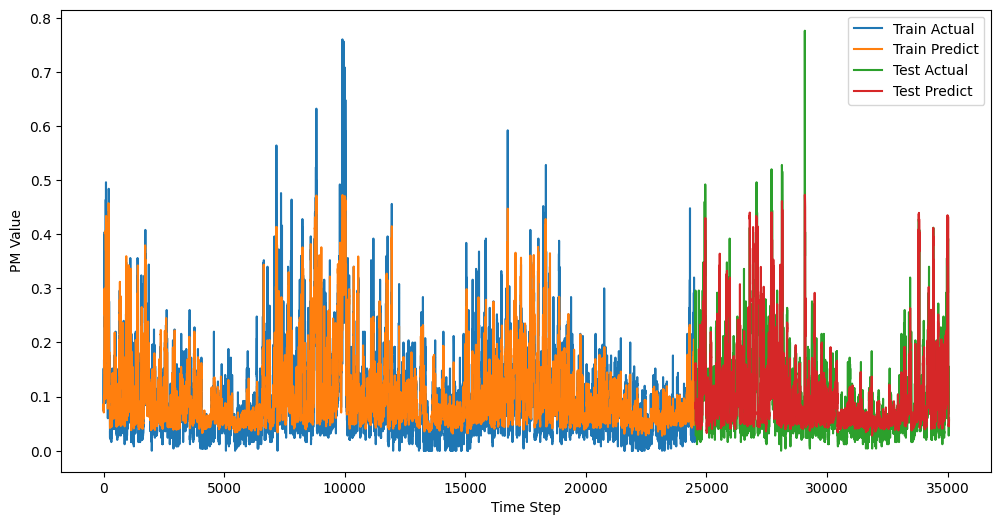

In [15]:
import matplotlib.pyplot as plt



# 실제값과 예측값을 시각화
plt.figure(figsize=(12, 6))

# 훈련 데이터의 실제값과 예측값
plt.plot(trainY, label='Train Actual')
plt.plot(trainPredict, label='Train Predict')

# 테스트 데이터의 실제값과 예측값
plt.plot(range(len(trainY), len(trainY) + len(testY)), testY, label='Test Actual')
plt.plot(range(len(trainY), len(trainY) + len(testY)), testPredict, label='Test Predict')

plt.xlabel('Time Step')
plt.ylabel('PM Value')
plt.legend()
plt.show()
